In [1]:
# modeling tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint, choice
from statsmodels.tsa.api import  SimpleExpSmoothing

# programming and optimization tools
import ipdb
from collections import Counter
from dataclasses import dataclass, field
from functools import partial
from scipy.optimize import minimize_scalar


# parameters for the notebook itself
%matplotlib inline


In [2]:
def dbl_SEWMA(data:pd.Series, alpha:float)->dict:
    # fits a simple exponential smoothing model with fixed alpha to a dataset
    # used by simulated school (districts) to predict enrollment
    ## Arguments
    # data: univariate time series
    # alpha: exponential smoothing parameter, between 0 and 1 
    ## Returns
    # dictionary containing the sum of squared errors and statsmodels time series model
    mod1 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=alpha, optimized=False)
    return {'sse':mod1.sse, 'mod':mod1}


In [3]:
def flat_with_noise(start_value:float=10.0, n_years:int=5, chgrat:float=0.20)->np.array:
    # generates a set of simulated enrollments that vary due to having noise
    ## Arguments
    ## Returns
    # np array of e
    output = np.zeros(n_years) + start_value
    chgsize = chgrat*start_value
    dmin = int(-1*chgsize)
    dmax = int(chgsize)
    output += np.array([randint(dmin, dmax) for x in range(n_years)])
    return(output)

In [4]:
def impulse(start_value=10., n_years=5, impyr=2, chgrat=.670, impsign=1):
    # function to produce an impulsive change 
    chgsize = chgrat*start_value
    out = np.array([start_value for x in range(n_years)]) 
    out[impyr:n_years] = impsign*chgsize +  out[impyr]
    return(out)

In [5]:
def cvx_change(start_value=10., n_years=5, chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    chgsize = chgrat*start_value
    
    alpha = np.exp(np.log(1+chgsign*chgrat)/n_years) - 1
    output = start_value * np.power(1. + alpha, np.linspace(1,n_years,n_years))
    
    return(output)

In [6]:
def ccv_change(start_value=10.,n_years=5,alpha=0.75,chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    adjust = 0.5*np.pi if chgsign < 0 else 0
    out = np.linspace(0,0.5*np.pi, n_years+1)
    out += adjust
    maxi = (1+chgrat*chgsign)*start_value
    mini = min(start_value, maxi)
    maxi = max(start_value, maxi)
    output = (maxi-mini)*np.sin(out) + mini
    return(output[1:])

In [7]:
# with individual growth patterns defined, store all in one easy-access place
growthPats = {'flat':flat_with_noise, 
              'impUp':impulse, 
              'impDn':partial(impulse, impsign=-1), 
              'cvxUp':cvx_change, 
              'cvxDn':partial(cvx_change, chgsign=-1),
              'ccvUp':ccv_change,
              'ccvDn':partial(ccv_change, chgsign=-1)
              }

In [8]:
def simulate_history(start_value=50, total_years=50, period_length=5, debug=False):
    # core function to generate a school (district's) population history
    history = [[start_value for x in range(period_length)]]
            # need to add functionality to smooth the transitions 
    
    for _, tp in enumerate(range(total_years//period_length)):
        locidx = randint(0,len(growthPats)-1) # there are 7 locidxs
        lochg = history[_][period_length-1] 
        locfun = list(growthPats.values())[locidx](start_value=lochg, n_years=period_length) 
        local_h = np.squeeze(locfun)
        history.append(local_h)
        if debug:
            '''debug info that shows which growth pattern is used and prints
               the starting value and simulated values for each multiyear 
            '''
            print(f"starting history {locidx}, a/k/a {repr(list(growthPats.values())[locidx])}")
            print(_)
            print(lochg)
            print(local_h)
            print("____")

    out = np.floor(np.hstack(history)[period_length:])
    print(out)
    return out[period_length:]


In [9]:
def predict_from_history(schooldata:pd.Series,alpha_set:list=[0.1,0.5,0.7],years:int=5)->dict:
    # core function to 
    # 
    school_SEWMA = lambda a: dbl_SEWMA(data=schooldata, alpha=a)
    fit_res = {}
    models = {}
    sorted 
    for j in alpha_set:
        # don't overwrite if there're multiples 
        if fit_res.get(j) is None: 
            ssmwa = school_SEWMA(j)
            fit_res[j] = ssmwa['sse']
            models[j] = ssmwa['mod']
        
    fit_check = pd.Series(fit_res)
    result = fit_check.index[fit_check.argmin()]
    return {"alpha_result":result, "prediction":models[result].forecast(years),"history":models[result].fittedvalues}

In [10]:
sim1 = simulate_history(start_value=5000,period_length=12)

[4991. 4965. 4923. 4866. 4793. 4707. 4608. 4500. 4382. 4258. 4130. 4000.
 3993. 3972. 3939. 3892. 3834. 3765. 3687. 3600. 3506. 3407. 3304. 3200.
 3200. 3200. 1056. 1056. 1056. 1056. 1056. 1056. 1056. 1056. 1056. 1056.
 1056. 1056. 1763. 1763. 1763. 1763. 1763. 1763. 1763. 1763. 1763. 1763.]


In [11]:
predicres1 = predict_from_history(schooldata=sim1[0:13],years=4)
predicres2 = predict_from_history(schooldata=sim1[0:25],years=4)
predicres3 = predict_from_history(schooldata=sim1[0:35],years=4)

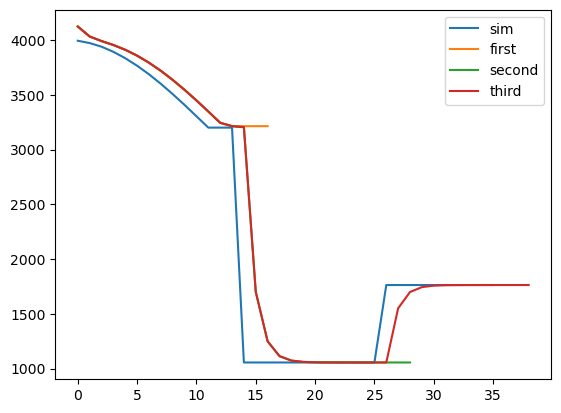

In [12]:
plt.plot(sim1)
plt.plot(np.hstack((predicres1['history'],  predicres1['prediction'])))
plt.plot(np.hstack((predicres2['history'],  predicres2['prediction'])))
plt.plot(np.hstack((predicres3['history'],  predicres3['prediction'])))
plt.legend(['sim', 'first', 'second','third'])

In [13]:
predicres1


{'alpha_result': 0.7,
 'prediction': array([3213.25783823, 3213.25783823, 3213.25783823, 3213.25783823]),
 'history': array([4123.33333333, 4032.1       , 3990.03      , 3954.309     ,
        3910.6927    , 3857.00781   , 3792.602343  , 3718.6807029 ,
        3635.60421087, 3544.88126326, 3448.36437898, 3347.30931369,
        3244.19279411])}

In [14]:
@dataclass
class SchoolDistrict:
    # core simulation class: represents the history of a single school district 
    # BASIC SIMULATION PARAMETERS (CONSTANTS)
    sscRat: int = 100 # student to school ratio
    tolerance: tuple = (-0.5, 0.25) # tolerances for that ratio
    alphas:tuple = tuple(np.linspace(0.1,0.9,9)) # starting set of exponential smoothing parameters 
    len_history:int = 60 # number of years to run the simulation
    growth_period:int = 10 # number of years to follow a particular growth patterndef simulate_history(start_value=50, total_years=50, period_length=5, debug=False):
    start_yr:int = 10 # year to begin forecasts
    # BASIC SIMULATION PARAMETERS (VARIABLE)
    NStudents:int = 1000 # initial number of students
    pred_ratios: list = field(default_factory=list)
    ach_ratios: list = field(default_factory=list)
    hist_alphas: list = field(default_factory=list)
    predictions: list = field(default_factory=list)
    hist_schools: list = field(default_factory=list)


    
    def simulate_full_history(self):
        # first step in the simulation--initialize the population history
        self.history=simulate_history(start_value=self.NStudents, total_years=self.len_history, period_length=self.growth_period)
        
    def make_construction_decisions(self,debug=True):
        # at the end of every year, make a forecast and update alpha selection probabilities
        self.NSchools = self.NStudents // (self.sscRat + self.tolerance[1])# initial number of schools--started to be near a phase transition 
        self.pselect = np.ones(len(self.alphas))/len(self.alphas) # selection probabilities for exponential smoothing parameters
        last_alpha = 0.0 # initalize the most recent choice of exponential smoothing param
        alpha_multiple, extra = divmod(self.len_history - self.start_yr, len(self.alphas)) # number of times to include an alpha in the list, 
        #--must guarantee that we won't run out of alphas
        local_as = list(self.alphas)*alpha_multiple  + [choice(self.alphas) for x in range(extra)]
        self.ach_ratios += list(np.zeros(self.start_yr)-1)
        self.predictions += list(np.zeros(self.start_yr))
        self.pred_ratios += list(np.zeros(self.start_yr))
        self.hist_alphas += list(np.zeros(self.start_yr))
        self.hist_schools += list(np.zeros(self.start_yr))

        for yr in range(self.start_yr, self.len_history-self.start_yr):
            
            # calculate ratio (evaluate performance) and update list of smoothing params
            local_achrat = self.history[yr-1]/self.NSchools # achieved ratio
            self.ach_ratios.append(local_achrat)
            self.hist_schools.append(self.NSchools)
            local_diff = (local_achrat - self.sscRat)/self.sscRat # achieved difference from ideal
            if yr > self.start_yr and last_alpha in local_as:
                if local_diff > self.tolerance[1]: #achieved ratio too high
                    local_as.remove(last_alpha)
                elif local_diff < self.tolerance[0]: #achieved ratio too low
                    local_as.remove(last_alpha)
                else: # ratio ok--good prediction
                    local_as.append(last_alpha)
                    


            # forecast 
            forecast_objs = predict_from_history(self.history[0:yr],years=1,alpha_set=local_as)
            local_prat = forecast_objs['prediction'][0]/self.NSchools
            self.hist_alphas.append(forecast_objs['alpha_result'])
            last_alpha = forecast_objs['alpha_result']
            local_ach_diff = (local_prat - self.sscRat)/self.sscRat# predicted difference from ideal
            self.predictions.append(forecast_objs['prediction'][0])
            self.pred_ratios.append(local_prat)

            # update number of schools based on forecast 
            self.NSchools = np.round(self.NSchools*(1 + local_ach_diff))
            # 
            if debug:
                print(len(local_as))
                print(local_as)
            
    
    
    

In [15]:
simSchool = SchoolDistrict(growth_period=5,tolerance=(-.01,.01),pred_ratios=[], ach_ratios=[], hist_alphas=[], predictions=[])

In [16]:
simSchool.simulate_full_history()

[1000. 1000.  330.  330.  330.  315.  301.  288.  276.  264.  252.  241.
  230.  220.  211.  211.  211.   69.   69.   69.   74.   77.   80.   82.
   83.   79.   76.   73.   69.   66.   66.   64.   61.   57.   53.   51.
   48.   46.   44.   42.   48.   40.   50.   46.   46.   48.   50.   52.
   54.   56.   59.   62.   65.   66.   67.   69.   72.   75.   78.   80.]


In [17]:
simSchool.make_construction_decisions()

50
[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.9, 0.30000000000000004, 0.2, 0.6]
49
[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.1, 0.9, 0.30000000000000004, 0.2, 0.6]
48
[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.1, 0.2,

C:\Users\cl140\AppData\Local\Temp\ipykernel_20696\2262675030.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  local_achrat = self.history[yr-1]/self.NSchools # achieved ratio
C:\Users\cl140\AppData\Local\Temp\ipykernel_20696\2262675030.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  local_prat = forecast_objs['prediction'][0]/self.NSchools
C:\Users\cl140\AppData\Local\Temp\ipykernel_20696\2262675030.py:66: RuntimeWarning: invalid value encountered in scalar multiply
  self.NSchools = np.round(self.NSchools*(1 + local_ach_diff))


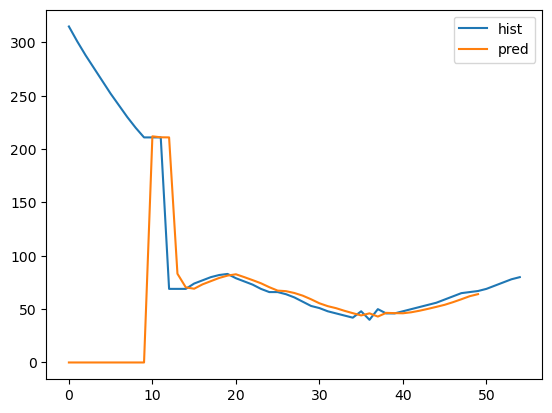

In [18]:
plt.plot(simSchool.history)
plt.plot(simSchool.predictions)
plt.legend(['hist','pred'])

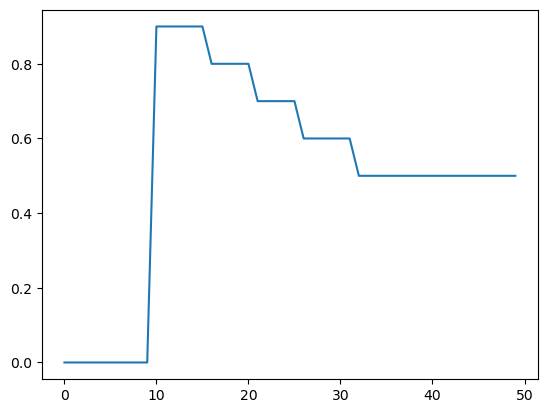

In [19]:
plt.plot(simSchool.hist_alphas)

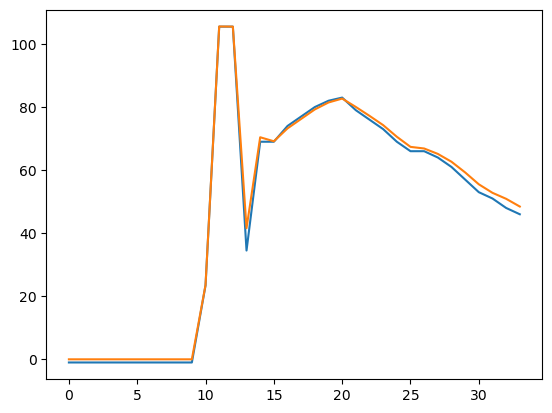

In [20]:
plt.plot(simSchool.ach_ratios)
plt.plot(simSchool.pred_ratios)

In [21]:
Counter(simSchool.hist_alphas)

Counter({0.5: 18, 0.0: 10, 0.9: 6, 0.6: 6, 0.8: 5, 0.7000000000000001: 5})

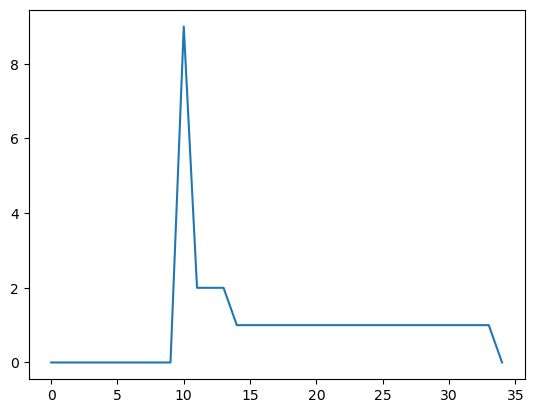

In [22]:
plt.plot(simSchool.hist_schools)